In [11]:
import numpy as np
import pandas as pd
from scipy import stats
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

sns.set()

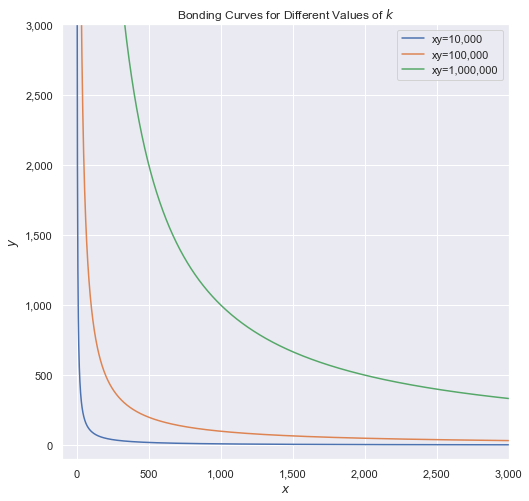

In [12]:
ks = [1e+4, 1e+5, 1e+6]
x = np.linspace(1, 3000, 3000)

fig, ax = plt.subplots(figsize=(8, 8))
for k in ks:
    y = k / x
    ax.plot(x, y, label=f'xy={k:,.0f}')
    
ax.set_title('Bonding Curves for Different Values of $k$')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.legend(loc='upper right')
ax.set_xlim(-100, 3000)
ax.set_ylim(-100, 3000)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.show()

In [13]:
pools = [
    'DAI-WETH-3000',
    'DAI-WETH-500',
    'USDC-WETH-3000',
    'USDC-WETH-500',
    'WETH-USDT-3000',
    'WETH-USDT-500',
    'WBTC-USDC-3000',
]

In [14]:
pool_returns = {}
for pool in pools:
    all_returns = pd.read_pickle(f'./eda_notebooks/saved-returns/{pool}.pickle')
    
    bin_returns = defaultdict(list)
    for day, irrs in all_returns.items():
        for bin_pos, irr in irrs.items():
            bin_no = int(re.findall(r'_bin(\d+)_', bin_pos)[0])
            bin_returns[bin_no].append(irr)
    
    pool_returns[pool] = bin_returns

In [15]:
def plot_pool_returns(pool_returns, ax=None, alpha=0.05):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 8))
    
    x_pos, x_labels, y, std_err = [], [], [], []
    for i in range(1, 23):
        x_pos.append(i)
        x_labels.append(f'{i - 11}$\sigma$')
        y.append(np.mean(pool_returns[i]))
        
        se = np.std(pool_returns[i]) / np.sqrt(len(pool_returns[i]))
        std_err.append(se)
    
    n = len(pool_returns[1])
    scale = stats.t.ppf(1 - alpha / 2, df=n - 1)
    y = np.array(y)
    std_err = np.array(std_err)

    ax.plot(x_pos, y)
    ax.fill_between(x_pos, y - scale * std_err, y + scale * std_err, alpha=0.25)

    ax.set_xticks(ticks=np.array(x_pos[:-1]) + 0.5, labels=x_labels[:-1])
    ax.set_title(f'Daily Mean Returns Per Bin, with {1 - alpha:,.2%} Confidence Interval')
    ax.set_xlabel('Bin Edge, as a Function of $\sigma$')
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2%}'))

    return ax

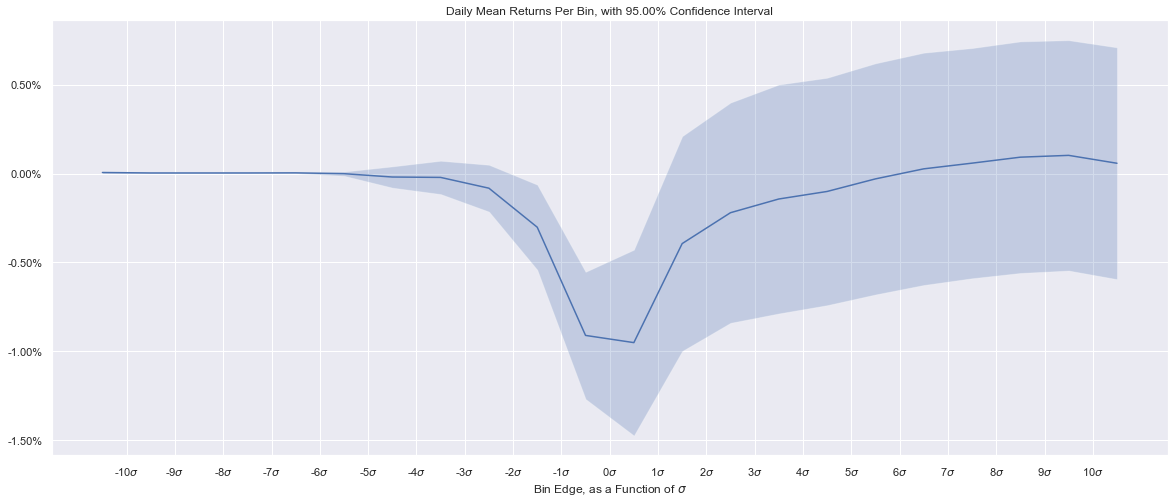

In [46]:
fig, ax = plt.subplots(figsize=(20, 8))
plot_pool_returns(pool_returns['WETH-USDT-500'], ax=ax, alpha=0.05)
plt.show()

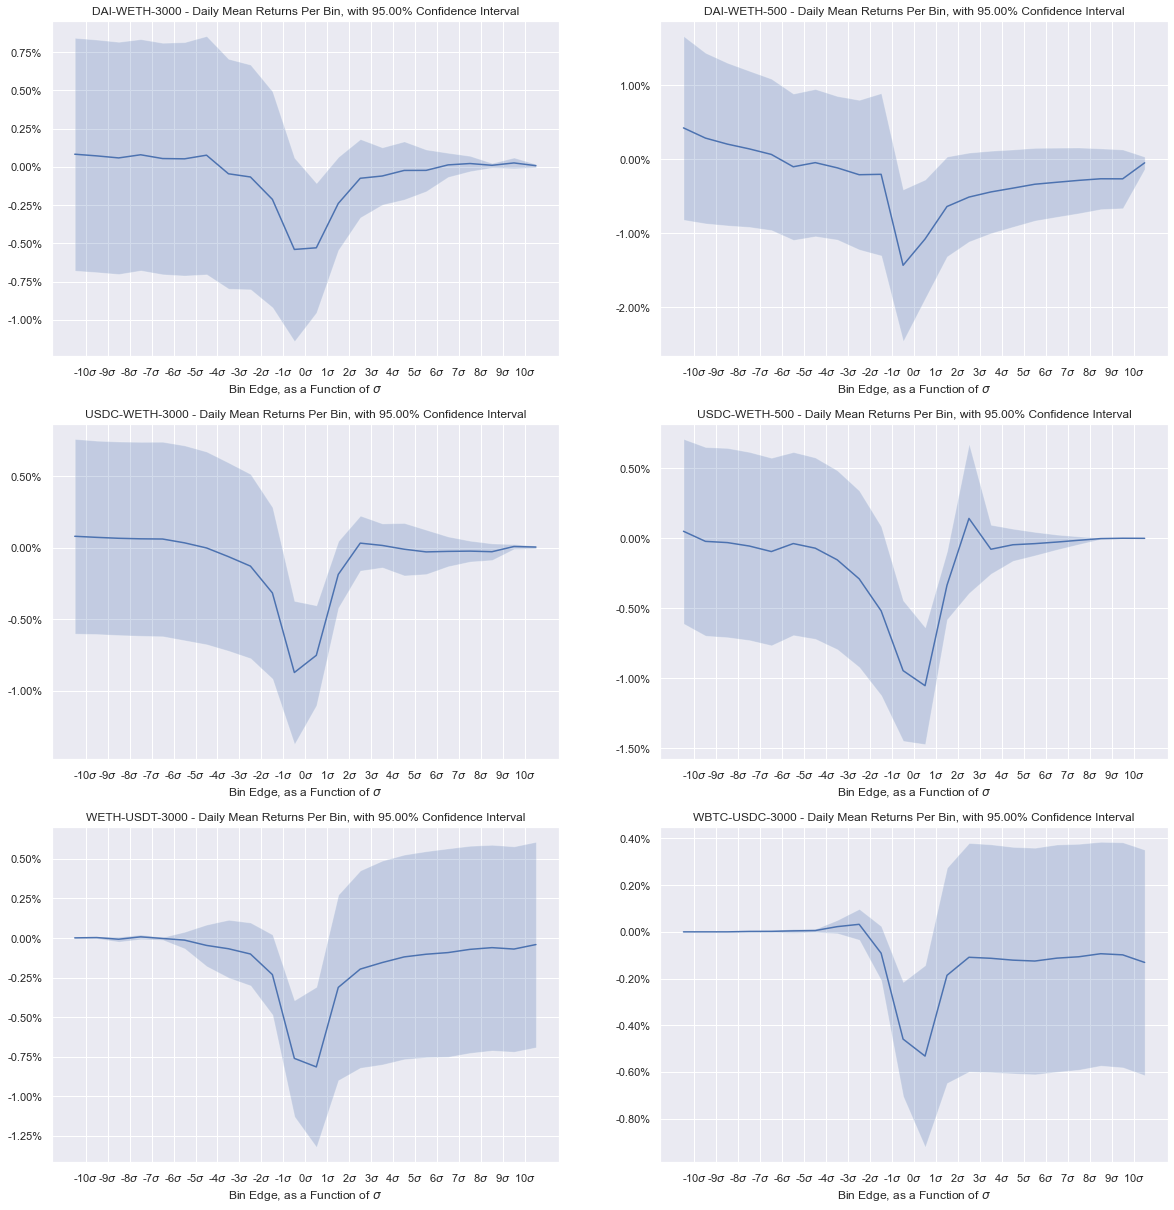

In [47]:
fig, ax = plt.subplots(3, 2, figsize=(20, 7 * 3))

i = 0
alpha = 0.05
for pool in pools:
    if pool == 'WETH-USDT-500':
        continue
    plot_pool_returns(pool_returns[pool], ax=ax.flatten()[i], alpha=alpha)
    ax.flatten()[i].set_title(
        f'{pool} - Daily Mean Returns Per Bin, '
        f'with {1 - alpha:,.2%} Confidence Interval'
    )
    i += 1

plt.show()

In [18]:
pool_snapshots = {}
for pool in pools:
    pool_snapshots[pool] = pd.read_pickle(f'./eda_notebooks/saved-pools/{pool}.pickle')

In [51]:
def plot_liquidity_curves_on_days(pool_snapshots, pool_id, days, interval, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, len(days), figsize=(20, 6))
    if not isinstance(ax, np.ndarray):
        ax = np.array([ax])

    for i, day in enumerate(days):
        pool = pool_snapshots[pool_id][day]
        pool.plot_liquidity_curve(ax=ax[i], interval=interval)
        ax[i].axvline(pool.price, color='k', linewidth=0.5)
        ax[i].set_title(f'Liquidity Curve - {day}')

    y_min = min([ax[i].get_ylim()[0] for i in range(len(days))]) 
    y_max = max([ax[i].get_ylim()[1] for i in range(len(days))]) 
    for i in range(len(days)):
        ax[i].set_ylim(y_min, y_max)
        
    return ax

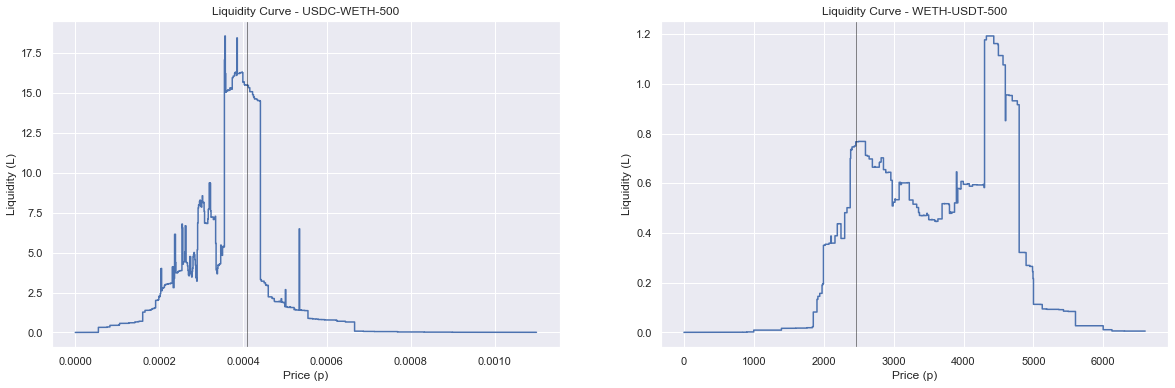

In [53]:
days = ['2022-01-27']
pool_ids = ['USDC-WETH-500', 'WETH-USDT-500']

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

_ = plot_liquidity_curves_on_days(pool_snapshots, pool_ids[0], days, 
                                  interval=(0, 0.001), ax=ax[0])
ax[0].set_title(f'Liquidity Curve - {pool_ids[0]}')

_ = plot_liquidity_curves_on_days(pool_snapshots, pool_ids[1], days, 
                                  interval=(0, 6000), ax=ax[1])
ax[1].set_title(f'Liquidity Curve - {pool_ids[1]}')

plt.show()

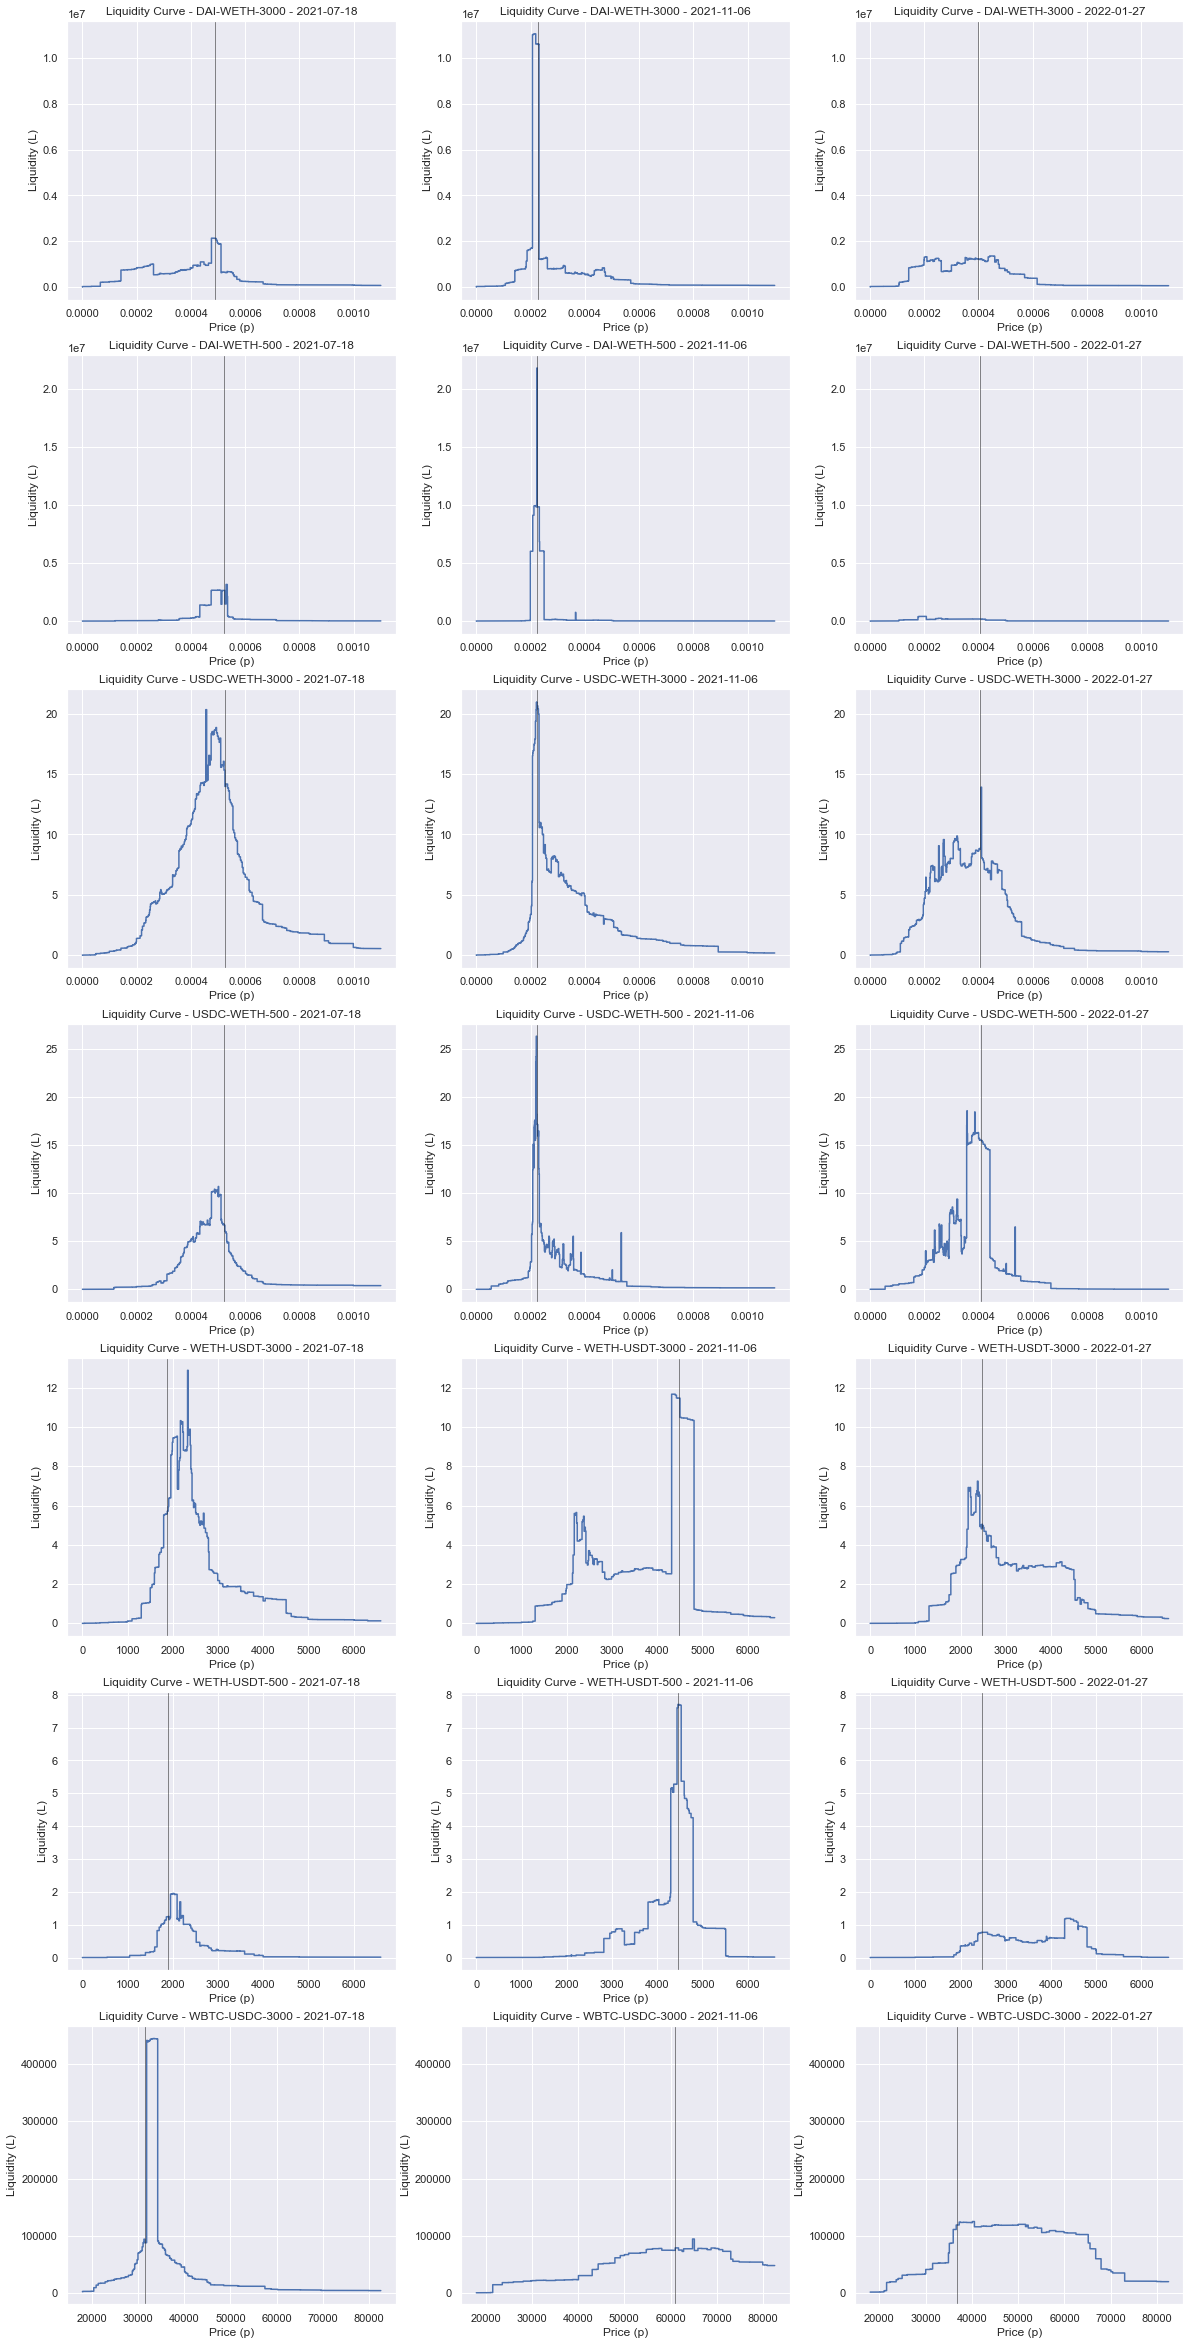

In [54]:
pool_intervals = {
    'DAI-WETH-3000': (0, 0.001),
    'DAI-WETH-500': (0, 0.001),
    'USDC-WETH-3000': (0, 0.001),
    'USDC-WETH-500': (0, 0.001),
    'WETH-USDT-3000': (0, 6000),
    'WETH-USDT-500': (0, 6000),
    'WBTC-USDC-3000': (20000, 75000),
}
fig, ax = plt.subplots(len(pool_intervals), 3, 
                       figsize=(20, 6 * len(pool_intervals)))

days = ['2021-07-18', '2021-11-06', '2022-01-27']
for i, (pool_id, interval) in enumerate(pool_intervals.items()):
    _ = plot_liquidity_curves_on_days(pool_snapshots, pool_id, days, 
                                      interval=interval, ax=ax[i])
    for j, day in enumerate(days):
        ax[i][j].set_title(f'Liquidity Curve - {pool_id} - {day}')

plt.show()